<a href="https://colab.research.google.com/github/AdrianMartinezRivas/Deep-learning-based-on-convolutional-neural-networks-to-classify-nanobiomechanical-data-/blob/main/CNN_for_Classifying_C_Albicans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  Libraries and modules
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import zipfile
import csv
import cv2
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow import keras
from keras.api._v2.keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path

## Dataset  structure


The structure of the dataset folders in the zip file is:

Nanodomain (1000 images)

Outside nanodomain (1000 images)

Intermediate (1000 images)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path =""

Mounted at /content/drive


In [ ]:
local_zip = '/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Data_Adrian.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = '/tmp/Data_Adrian'

#Directions for each class:
Nano_dir = os.path.join(base_dir, 'Nanodomain')
Inter_dir = os.path.join(base_dir, 'Intermediate')
Out_dir = os.path.join(base_dir, 'Outside')

nanodomain_fnames = os.listdir(Nano_dir)
inter_fnames = os.listdir(Inter_dir)
outside_fnames = os.listdir(Out_dir)

(676, 628, 3)


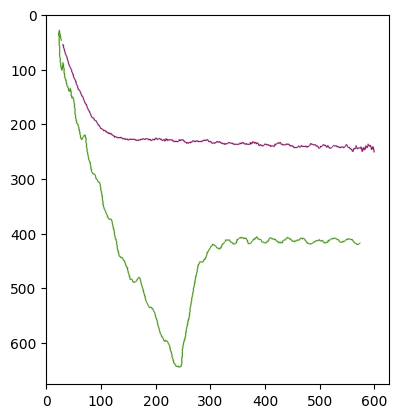

In [ ]:
# Example of an image from the Nanodomain class

filename = Nano_dir + '/' + 'Nanodomain56.jpg'
# Load the image in memory
image = matplotlib.image.imread(filename)
# Print the image shape
print(image.shape)
# Display the image
plt.imshow(image)
plt.show()

(676, 628, 3)


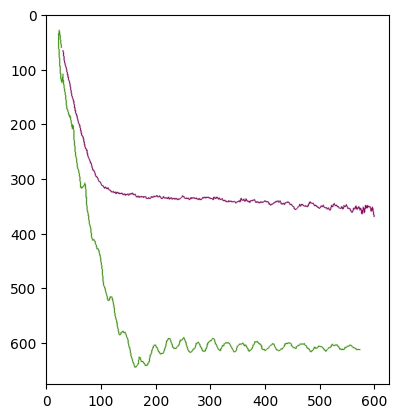

In [ ]:
# Example of an image from the Intermediate

filename = Inter_dir + '/' + 'Intermediate1.jpg'
# Load the image in memory
image = matplotlib.image.imread(filename)
# Print the image shape
print(image.shape)
# Display the image
plt.imshow(image)
plt.show()

(676, 628, 3)


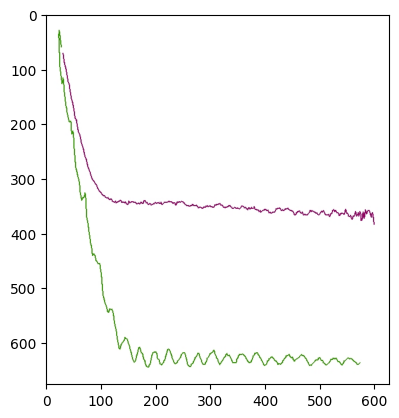

In [ ]:
# Example of an image from the Outside Nanodomain

filename = Out_dir + '/' + 'Outside64.jpg'
# Load the image in memory
image = matplotlib.image.imread(filename)
# Print the image shape
print(image.shape)
# Display the image
plt.imshow(image)
plt.show()

In [ ]:
#To import data and create de validation method
#image size
img_sz=224
#Batch size
batch_s=32

#The validation method is Hold-out 80-20:
data_generator = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, rotation_range=20, zoom_range=0.2, shear_range=0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.20)
train_iterator = data_generator.flow_from_directory(base_dir, subset="training", class_mode='categorical', batch_size=batch_s, target_size=(img_sz, img_sz))
validation_iterator = data_generator.flow_from_directory(base_dir, subset="validation", class_mode='categorical', batch_size=batch_s, target_size=(img_sz, img_sz), shuffle=False)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
# To save the model we give the name: model(100epochs)-GPU.h5
model_path = '/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/mode19-2-2024.h5'

In [ ]:
#Creating our model
inputs= keras.Input(shape=(img_sz, img_sz, 3))
x=layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x=layers.MaxPooling2D((2, 2))(x)
x=layers.Conv2D(64, (3, 3), activation='relu')(x)
x=layers.MaxPooling2D((2, 2))(x)
x=layers.Conv2D(128, (3, 3), activation='relu')(x)
x=layers.MaxPooling2D((2, 2))(x)
x=layers.Conv2D(256, (3, 3), activation='relu')(x)
x=layers.MaxPooling2D((2, 2))(x)
x=layers.Conv2D(256, (3, 3), activation='relu')(x)
x=layers.Flatten()(x)
x=layers.Dense(512,activation='relu')(x)
x=layers.Dense(128,activation='relu')(x)
outputs=layers.Dense(3, activation='softmax')(x)
model=keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856 

In [ ]:
#Checkpoints, to save the best result of the training in the .h5 file

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    verbose=1,
    mode='min',
    save_best_only=True)

In [ ]:
#Fit function to train the model

epocas=100 #Number of epochs
STEP_SIZE_TRAIN=train_iterator.n//train_iterator.batch_size
STEP_SIZE_VALIDATION=validation_iterator.n//validation_iterator.batch_size

history=model.fit(train_iterator,
                  steps_per_epoch=STEP_SIZE_TRAIN,
                  epochs=epocas,
                  validation_data=validation_iterator,
                  validation_steps=STEP_SIZE_VALIDATION,
                  callbacks=[model_checkpoint_callback])

Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 1.0983 - accuracy: 0.3525
Epoch 1: val_loss improved from inf to 1.08767, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/mode19-2-2024B.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 52s 616ms/step - loss: 1.0983 - accuracy: 0.3525 - val_loss: 1.0877 - val_accuracy: 0.3472
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 0.9554 - accuracy: 0.4963
Epoch 2: val_loss improved from 1.08767 to 0.78514, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/mode19-2-2024B.h5
75/75 [==============================] - 50s 664ms/step - loss: 0.9554 - accuracy: 0.4963 - val_loss: 0.7851 - val_accuracy: 0.6024
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.6567
Epoch 3: val_loss improved from 0.78514 to 0.63237, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/mode19-2-2024B.h5
75/75 [==============================] - 42s 566ms/step - loss: 0.6644 - accuracy: 0.6567 - val_loss: 0.6324 - val_accuracy: 0.6753
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.7200
Epoch 4: val_loss improved from

# Generating the confusion matrix and metrics:

In [ ]:
#Load the model previously training
model_n = keras.models.load_model('/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/mode19-2-2024.h5')

In [ ]:
#Load the model previously training
model_n = keras.models.load_model('/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/model_Adrian2Curvas(100epochs)224size32FINAL-Api.h5')

In [ ]:
#Predict with validation set
y1_pred = model_n.predict(validation_iterator, validation_iterator.n // batch_s+1)
y_pred = np.argmax(y1_pred, axis=1)
print(validation_iterator.class_indices)

19/19 [==============================] - 12s 460ms/step
{'Intermediate': 0, 'Nanodomain': 1, 'Outside': 2}


In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          ):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
       group_percentages = blanks
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

#plt.xticks(tick_marks,classes,rotation=45,fontsize=15)
  #plt.yticks(tick_marks,classes,fontsize=15,rotation=90)

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,  annot_kws={
                'fontsize': 18},annot=box_labels,fmt="",cmap=cmap,cbar=cbar  ,xticklabels=categories,yticklabels=categories)
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

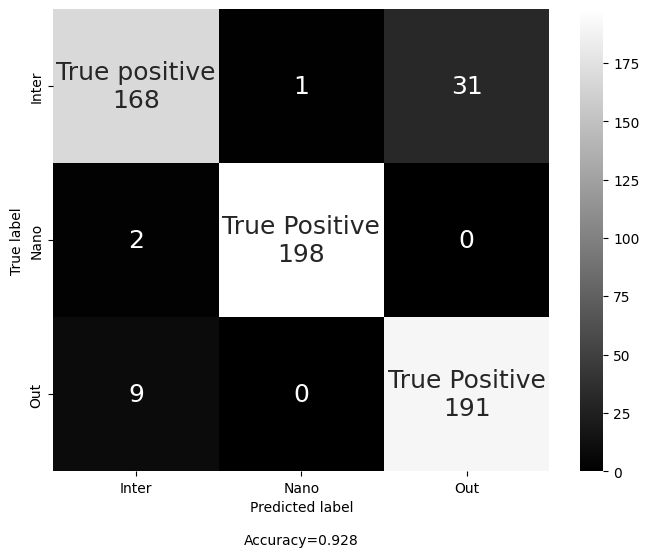

In [ ]:
from numpy.ma.core import size
cm=confusion_matrix(validation_iterator.classes, y_pred)
labels = ['True positive','','','','True Positive','','','','True Positive']
categories = ['Inter', 'Nano', "Out"]
disp=make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='gray',figsize=(8,6))

Confusion Matrix


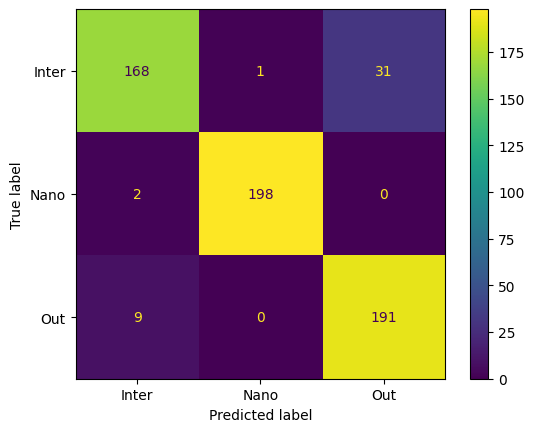

In [ ]:
#Confusion Matrix
labels=['Inter', 'Nano', "Out"]
print('Confusion Matrix')
cm=confusion_matrix(validation_iterator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

In [ ]:
#Classification Report:

print('Classification Report')
print(classification_report(validation_iterator.classes, y_pred, target_names=labels))

Classification Report
              precision    recall  f1-score   support

       Inter       0.94      0.84      0.89       200
        Nano       0.99      0.99      0.99       200
         Out       0.86      0.95      0.91       200

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



# Generating Training and validation losses, Training and validation accuracy:

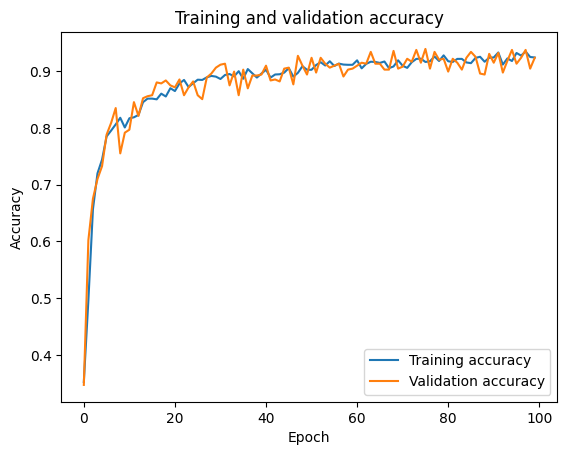

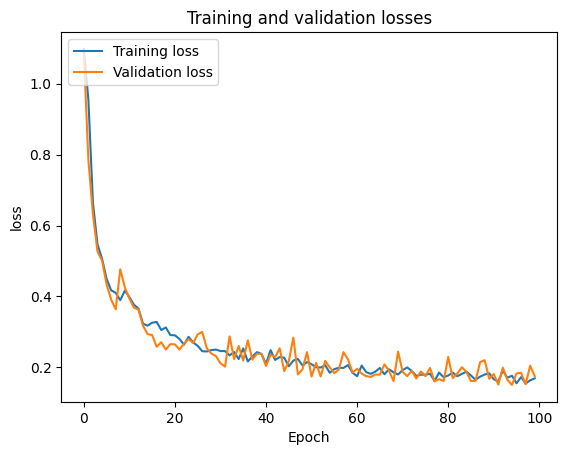

In [ ]:
#To see the model behavior during training
#Accuracy graph
def visualize_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Training and validation accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
  plt.show()
#Loss function graph
def visualize_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training and validation losses')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Training loss', 'Validation loss'], loc='upper left')
  plt.show()
#Accuracy graphic
visualize_accuracy(history)

#Loss function graphic
visualize_loss(history)

## Performing the testing

In [ ]:
# Unzip the zip file (testing images)
local_zip = '/content/drive/MyDrive/FilesforDL/CecileEtEtienne/TestingAdrian.zip' #300 images of each class
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
test_dir = '/tmp/TestAdrian' #300 images of each classe


In [ ]:
#Testing images batch size
batch_s=32
img_sz=224
#Import the testing images
data_generator = ImageDataGenerator(rescale=1.0/255.0)
test_iterator = data_generator.flow_from_directory(test_dir, class_mode=None, batch_size=batch_s,
                                                           target_size=(img_sz, img_sz),shuffle=False)

Found 900 images belonging to 1 classes.


In [ ]:
#loading the trained model
model_n1 = load_model('/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/mode19-2-2024.h5')

In [ ]:
#Load the model previously training
model_n1 = keras.models.load_model('/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/model_Adrian2Curvas(100epochs)224size32FINAL-Api.h5')

In [ ]:
#Predict the class with the test images
t1_pred = model_n1.predict(test_iterator, test_iterator.n // batch_s+1)     #Result with percentages
t_pred = np.argmax(t1_pred, axis=1)

29/29 [==============================] - 3s 110ms/step


In [ ]:
#Images names
filenames=test_iterator.filenames

In [ ]:
#See the result with percentages
print(t_pred)

[2 2 2 1 1 1 2 1 0 1 2 0 0 0 0 2 1 2 2 1 1 0 1 0 1 2 2 1 1 0 2 0 0 1 0 1 1
 1 2 0 2 2 2 0 2 1 2 1 2 2 1 2 0 0 0 2 1 1 1 2 2 1 0 0 2 2 1 0 0 0 0 1 0 0
 1 1 0 1 0 1 2 1 2 0 0 0 1 2 0 0 2 1 1 1 2 1 1 0 2 0 1 1 0 1 1 0 0 0 1 2 0
 1 2 0 1 2 0 2 2 0 2 2 2 1 0 1 0 2 0 2 0 1 0 0 0 0 0 1 2 2 2 1 1 2 1 0 0 1
 1 2 1 1 1 1 0 2 1 2 2 2 2 0 1 2 1 1 2 0 1 1 2 2 0 1 2 1 0 0 1 2 1 2 1 1 1
 1 2 0 1 1 0 0 1 1 2 1 0 1 1 2 0 0 1 0 2 0 1 2 2 1 2 0 0 0 0 0 2 0 2 0 1 2
 2 1 2 0 2 2 2 2 1 2 1 0 1 0 1 1 0 0 0 1 1 2 1 0 0 2 2 1 2 2 0 2 0 0 1 1 1
 0 1 1 0 1 0 0 0 2 2 1 2 0 0 0 0 1 0 1 2 0 2 2 0 2 2 2 1 0 0 2 2 2 1 0 1 2
 2 1 1 1 2 1 1 1 2 2 0 2 0 1 0 2 1 1 1 0 2 2 2 2 2 0 0 2 2 2 0 2 1 1 2 1 2
 0 1 2 0 1 1 1 0 0 0 2 2 2 0 1 2 2 0 2 0 1 0 1 2 2 2 2 0 1 0 0 2 2 1 0 1 2
 2 2 2 0 1 1 2 1 0 0 0 2 2 1 1 1 1 2 1 2 1 2 1 0 1 1 2 2 2 2 2 2 0 0 2 0 0
 0 2 0 1 2 0 0 1 0 0 1 1 2 1 2 0 0 0 2 1 0 1 0 1 2 0 1 1 0 0 1 0 1 1 1 2 1
 0 2 0 1 0 0 0 1 1 2 2 1 1 1 2 2 2 2 0 0 2 1 2 2 0 0 1 2 0 1 1 2 0 0 1 2 1
 2 2 2 0 0 2 2 0 2 2 1 1 

{'Test': 0}
1/1 [==============================] - 0s 480ms/step
[[3.2725625e-03 8.3210688e-11 9.9672747e-01]]


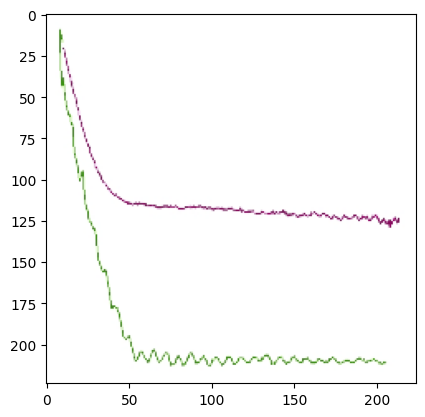

In [ ]:
print(test_iterator.class_indices)
filename = test_dir + '/' + filenames[300]
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(224,224))
image = image / 255

plt.imshow(image)

prediction = model_n.predict(image.reshape((1,224,224,3)))

print(prediction)

In [ ]:
#Count the number of images predicted in each class
unique, counts = np.unique(t_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 291, 1: 309, 2: 300}


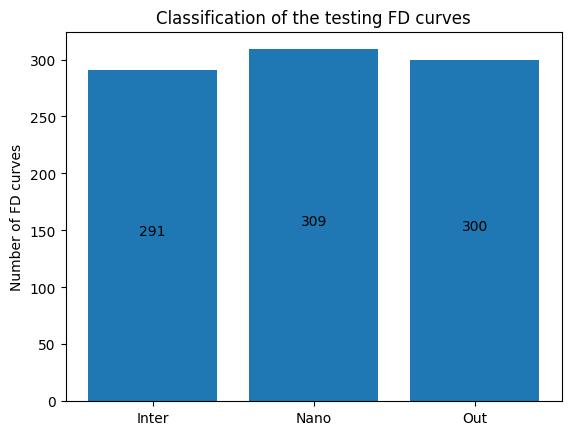

In [ ]:
#Histogram
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)+1):
        plt.annotate(y_list[i-len(y_list)],(i,y_list[i-len(y_list)]/2),ha="center")

clases = ['Inter', 'Nano', 'Out']   #ocupar la lista labels creada anteriormente
fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('Number of FD curves')
#Colocamos una etiqueta en el eje X
#ax.set_title('Classification in a testing dataset')
ax.set_title('Classification of the testing FD curves')
#Creamos la grafica de barras
plt.bar(clases, counts)
add_value_label(clases,counts)
#plt.savefig('barras_simple.png')       #para guardar la imágen
#Finalmente mostramos la grafica con el metodo show()
plt.show()

## Testing on the full matrix of 16384 FD curves

In [ ]:
# Unzip the zip file (testing images)
local_zip = '/content/drive/MyDrive/FilesforDL/CecileEtEtienne/TestingalltheCurves.zip'


zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
test_dir = '/tmp/TestingalltheCurves'
#Testing images batch size
batch_s=32
img_sz=224
#Import the testing images
data_generator = ImageDataGenerator(rescale=1.0/255.0)
test_iterator = data_generator.flow_from_directory(test_dir, class_mode=None, batch_size=batch_s,
                                                           target_size=(img_sz, img_sz),shuffle=False)
model_n1 = load_model('/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/mode19-2-2024.h5')
#Predict the class with the test images
t1_pred = model_n1.predict(test_iterator, test_iterator.n // batch_s+1)     #Result with percentages
t_pred = np.argmax(t1_pred, axis=1)

Found 16384 images belonging to 1 classes.
512/512 [==============================] - 47s 91ms/step


In [ ]:
#Count the number of images predicted in each class
unique, counts = np.unique(t_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3860, 1: 8906, 2: 3618}


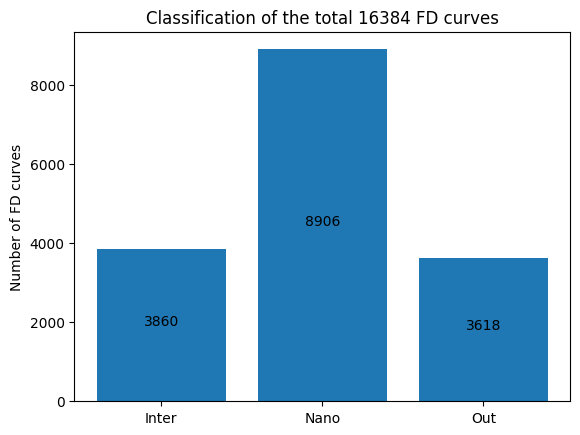

In [ ]:
#Histogram
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)+1):
        plt.annotate(y_list[i-len(y_list)],(i,y_list[i-len(y_list)]/2),ha="center")

clases = ['Inter', 'Nano', 'Out']   #ocupar la lista labels creada anteriormente
fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('Number of FD curves')
#Colocamos una etiqueta en el eje X
#ax.set_title('Classification in a testing dataset')
ax.set_title('Classification of the total 16384 FD curves')
#Creamos la grafica de barras
plt.bar(clases, counts)
add_value_label(clases,counts)
#plt.savefig('barras_simple.png')       #para guardar la imágen
#Finalmente mostramos la grafica con el metodo show()
plt.show()

## Petrained VGG16:

## 1.- without fine-tuning:

In [ ]:
local_zip = '/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Data_Adrian.zip'


zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = '/tmp/Data_Adrian'
#Directions for each class
Nano_dir = os.path.join(base_dir, 'Nanodomain')
Inter_dir = os.path.join(base_dir, 'Intermediate')
Out_dir = os.path.join(base_dir, 'Outside')

nanodomain_fnames = os.listdir(Nano_dir)
inter_fnames = os.listdir(Inter_dir)
outside_fnames = os.listdir(Out_dir)

In [ ]:
#image size
img_sz=224
#Batch size
batch_s=32
#To import data and create de validation method
#The validation method is Hold-out 80-20
data_generator = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, rotation_range=20, zoom_range=0.2, shear_range=0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.20)
train_iterator = data_generator.flow_from_directory(base_dir, subset="training", class_mode='categorical', batch_size=batch_s, target_size=(img_sz, img_sz))
validation_iterator = data_generator.flow_from_directory(base_dir, subset="validation", class_mode='categorical', batch_size=batch_s, target_size=(img_sz, img_sz), shuffle=False)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer="Adam", fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = layers.Dense(512,activation='relu')(top_model)
    top_model = layers.Dense(128,activation='relu')(top_model)
    #top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
BATCH_SIZE = 32
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=3

n_steps = train_iterator.samples // BATCH_SIZE
n_val_steps = validation_iterator.samples // BATCH_SIZE
n_epochs = 100

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# To save the model
Pretrainpathvgg = '/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16NotFineTunnig15-2-2024.h5'

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath=Pretrainpathvgg,
      save_best_only=True,
      monitor="val_loss",
      verbose=1,
      mode='min')

]

history = vgg_model.fit(
    train_iterator,
    batch_size=BATCH_SIZE,
    epochs=n_epochs,
    validation_data=validation_iterator,
    steps_per_epoch=n_steps,
    validation_steps=n_val_steps,
    callbacks=callbacks,verbose=1)

Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 0.9912 - accuracy: 0.6804
Epoch 1: val_loss improved from inf to 0.39178, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16NotFineTunnig15-2-2024.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 54s 601ms/step - loss: 0.9912 - accuracy: 0.6804 - val_loss: 0.3918 - val_accuracy: 0.8385
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 0.4122 - accuracy: 0.8100
Epoch 2: val_loss improved from 0.39178 to 0.29831, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16NotFineTunnig15-2-2024.h5
75/75 [==============================] - 47s 630ms/step - loss: 0.4122 - accuracy: 0.8100 - val_loss: 0.2983 - val_accuracy: 0.8628
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8617
Epoch 3: val_loss improved from 0.29831 to 0.26342, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16NotFineTunnig15-2-2024.h5
75/75 [==============================] - 50s 668ms/step - loss: 0.3204 - accuracy: 0.8617 - val_loss: 0.2634 - val_accuracy: 0.8785
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss: 0.3423 - accura

## Generating the confusion matrix and metrics:

In [ ]:
#Load the model previously training
model_n = keras.models.load_model('/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16NotFineTunnig15-2-2024.h5')

In [ ]:
#Predict with validation set
y1_pred = model_n.predict(validation_iterator, validation_iterator.n // batch_s+1)
y_pred = np.argmax(y1_pred, axis=1)
print(validation_iterator.class_indices)

19/19 [==============================] - 13s 673ms/step
{'Intermediate': 0, 'Nanodomain': 1, 'Outside': 2}


Confusion Matrix


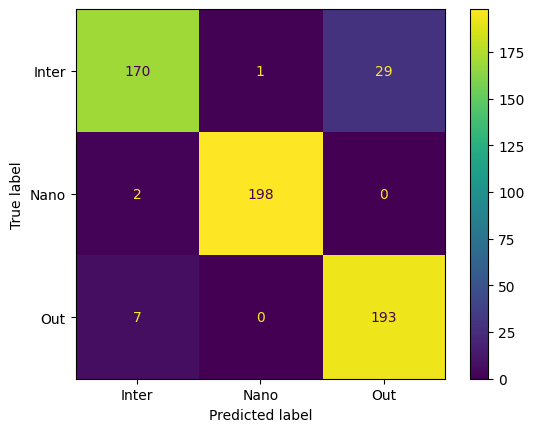

In [ ]:
#Confusion Matrix
labels=['Inter', 'Nano', "Out"]
print('Confusion Matrix')
cm=confusion_matrix(validation_iterator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

In [ ]:
#Classification Report
print('Classification Report')
print(classification_report(validation_iterator.classes, y_pred, target_names=labels))

Classification Report
              precision    recall  f1-score   support

       Inter       0.95      0.85      0.90       200
        Nano       0.99      0.99      0.99       200
         Out       0.87      0.96      0.91       200

    accuracy                           0.94       600
   macro avg       0.94      0.93      0.93       600
weighted avg       0.94      0.94      0.93       600



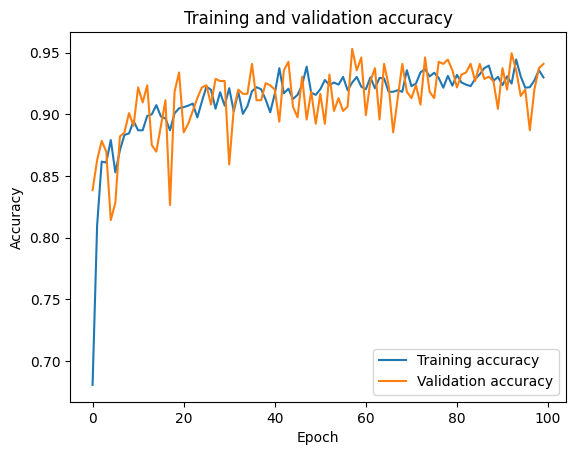

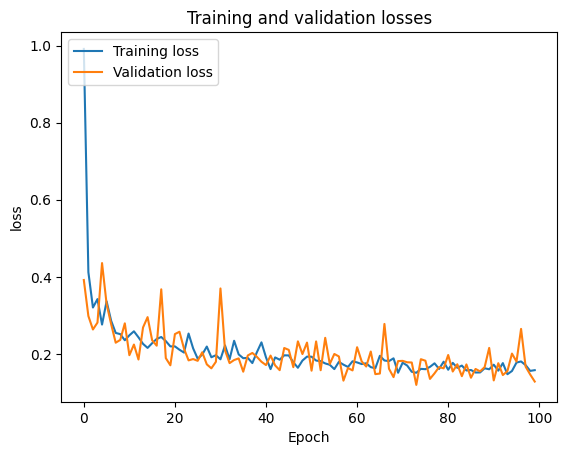

In [ ]:
#To see the model behavior during training
#Accuracy graph
def visualize_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Training and validation accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
  plt.show()
#Loss function graph
def visualize_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training and validation losses')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Training loss', 'Validation loss'], loc='upper left')
  plt.show()
#Accuracy graphic
visualize_accuracy(history)

#Loss function graphic
visualize_loss(history)

   ## Testing without fine-tuning  (pretrained VGG16)

In [ ]:
# Unzip the zip file (testing images)
local_zip = '/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Data_Adrian_test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
#test_dir = '/tmp/Test' #300 images of each class
test_dir = '/tmp/Test'
#Testing images batch size
batch_s=32
img_sz=224
#Import the testing images
data_generator = ImageDataGenerator(rescale=1.0/255.0)
test_iterator = data_generator.flow_from_directory(test_dir, class_mode=None, batch_size=batch_s,
                                                           target_size=(img_sz, img_sz),shuffle=False)
model_n1 = load_model('/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16NotFineTunnig15-2-2024.h5')
#Predict the class with the test images
t1_pred = model_n1.predict(test_iterator, test_iterator.n // batch_s+1)     #Result with percentages
t_pred = np.argmax(t1_pred, axis=1)

Found 900 images belonging to 1 classes.
29/29 [==============================] - 5s 168ms/step


In [ ]:
#Count the number of images predicted in each class
unique, counts = np.unique(t_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 365, 1: 307, 2: 228}


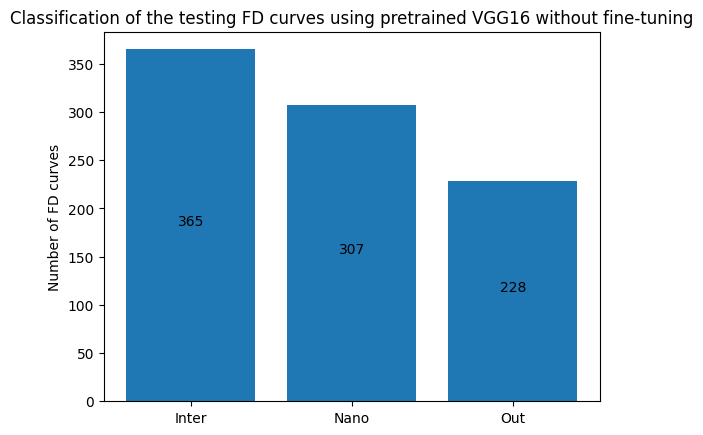

In [ ]:
#Histogram
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)+1):
        plt.annotate(y_list[i-len(y_list)],(i,y_list[i-len(y_list)]/2),ha="center")

clases = ['Inter', 'Nano', 'Out']   #ocupar la lista labels creada anteriormente
fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('Number of FD curves')
#Colocamos una etiqueta en el eje X
#ax.set_title('Classification in a testing dataset')
ax.set_title('Classification of the testing FD curves using pretrained VGG16 without fine-tuning')
#Creamos la grafica de barras
plt.bar(clases, counts)
add_value_label(clases,counts)
#plt.savefig('barras_simple.png')       #para guardar la imágen
#Finalmente mostramos la grafica con el metodo show()
plt.show()

##  <span style="color:red"> Conclusion: Accuracy and loss of training validation are noisy. Prediction on the test dataset is not as good as with our model.  </span>

# 2.- With Fine-Tuning:

In [ ]:
BATCH_SIZE = 32
input_shape = (224, 224, 3)
n_classes=3

n_steps = train_iterator.samples // BATCH_SIZE
n_val_steps = validation_iterator.samples // BATCH_SIZE
n_epochs = 100

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

In [ ]:
# To save the model
Pretrainwithpathvgg = '/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16WithFineTunnig15-2-2024.h5'

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath=Pretrainwithpathvgg,
      save_best_only=True,
      monitor="val_loss",
      verbose=1,
      mode='min')

]

vgg_ft_history = vgg_model_ft.fit(train_iterator,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_iterator,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=callbacks,verbose=1)

Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.7188
Epoch 1: val_loss improved from inf to 0.33410, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16WithFineTunnig15-2-2024.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 54s 694ms/step - loss: 0.5631 - accuracy: 0.7188 - val_loss: 0.3341 - val_accuracy: 0.8490
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.8846
Epoch 2: val_loss improved from 0.33410 to 0.24321, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16WithFineTunnig15-2-2024.h5
75/75 [==============================] - 57s 757ms/step - loss: 0.2696 - accuracy: 0.8846 - val_loss: 0.2432 - val_accuracy: 0.8872
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.8992
Epoch 3: val_loss improved from 0.24321 to 0.22216, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16WithFineTunnig15-2-2024.h5
75/75 [==============================] - 48s 636ms/step - loss: 0.2298 - accuracy: 0.8992 - val_loss: 0.2222 - val_accuracy: 0.8924
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss: 0.2170 - accu

## Generating the confusion matrix and metrics:

In [ ]:
#Load the model previously training
model_n = keras.models.load_model('/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16WithFineTunnig15-2-2024.h5')

In [ ]:
#Predict with validation set
y1_pred = model_n.predict(validation_iterator, validation_iterator.n // batch_s+1)
y_pred = np.argmax(y1_pred, axis=1)
print(validation_iterator.class_indices)

19/19 [==============================] - 9s 484ms/step
{'Intermediate': 0, 'Nanodomain': 1, 'Outside': 2}


Confusion Matrix


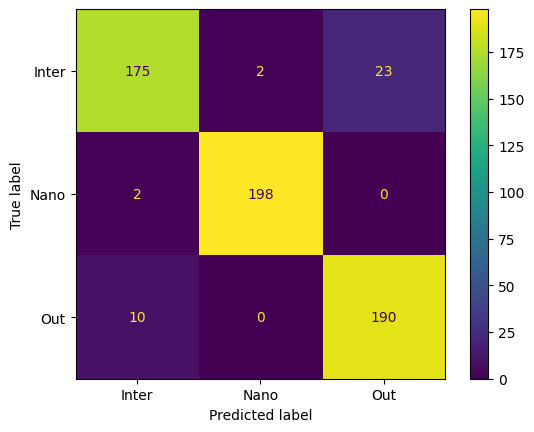

In [ ]:
#Confusion Matrix
labels=['Inter', 'Nano', "Out"]
print('Confusion Matrix')
cm=confusion_matrix(validation_iterator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

In [ ]:
#Classification Report
print('Classification Report')
print(classification_report(validation_iterator.classes, y_pred, target_names=labels))

Classification Report
              precision    recall  f1-score   support

       Inter       0.94      0.88      0.90       200
        Nano       0.99      0.99      0.99       200
         Out       0.89      0.95      0.92       200

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



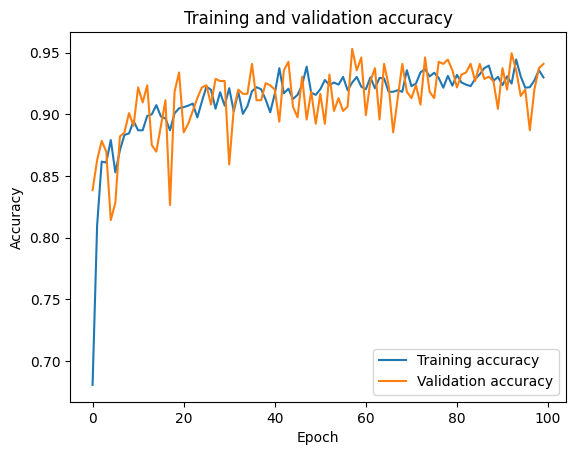

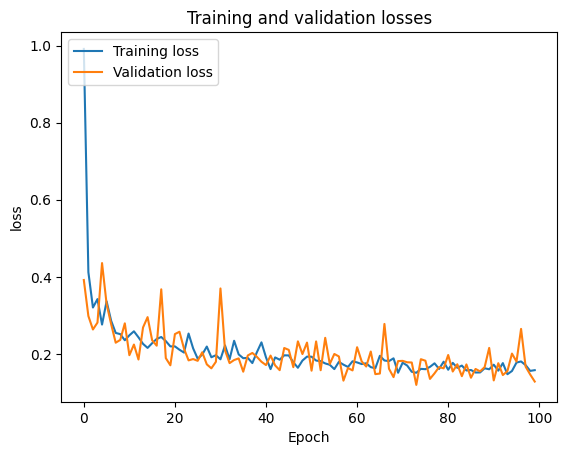

In [ ]:
#To see the model behavior during training
#Accuracy graph
def visualize_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Training and validation accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
  plt.show()
#Loss function graph
def visualize_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training and validation losses')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Training loss', 'Validation loss'], loc='upper left')
  plt.show()
#Accuracy graphic
visualize_accuracy(history)

#Loss function graphic
visualize_loss(history)

## Testing with fine-tuning  (pretrained VGG16):

In [ ]:
# Unzip the zip file (testing images)
local_zip = '/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Data_Adrian_test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
#test_dir = '/tmp/Test' #300 images of each class
test_dir = '/tmp/Test'
#Testing images batch size
batch_s=32
img_sz=224
#Import the testing images
data_generator = ImageDataGenerator(rescale=1.0/255.0)
test_iterator = data_generator.flow_from_directory(test_dir, class_mode=None, batch_size=batch_s,
                                                           target_size=(img_sz, img_sz),shuffle=False)
model_n1 = load_model('/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/PretrainVGG16WithFineTunnig15-2-2024.h5')
#Predict the class with the test images
t1_pred = model_n1.predict(test_iterator, test_iterator.n // batch_s+1)     #Result with percentages
t_pred = np.argmax(t1_pred, axis=1)

Found 900 images belonging to 1 classes.
29/29 [==============================] - 16s 305ms/step


In [ ]:
#Count the number of images predicted in each class
unique, counts = np.unique(t_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 291, 1: 312, 2: 297}


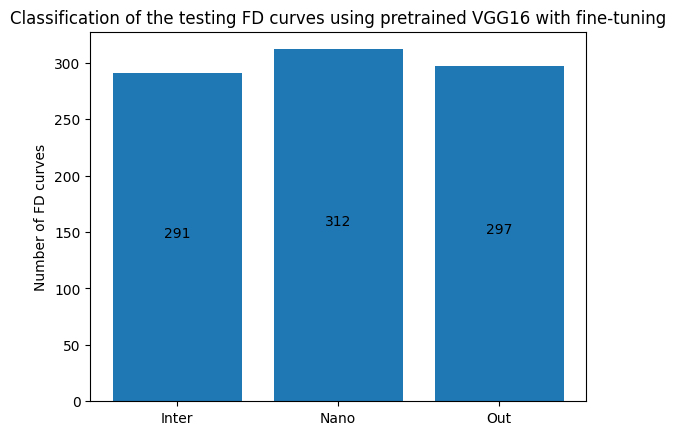

In [ ]:
#Histogram
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)+1):
        plt.annotate(y_list[i-len(y_list)],(i,y_list[i-len(y_list)]/2),ha="center")

clases = ['Inter', 'Nano', 'Out']   #ocupar la lista labels creada anteriormente
fig, ax = plt.subplots()
#Colocamos una etiqueta en el eje Y
ax.set_ylabel('Number of FD curves')
#Colocamos una etiqueta en el eje X
#ax.set_title('Classification in a testing dataset')
ax.set_title('Classification of the testing FD curves using pretrained VGG16 with fine-tuning')
#Creamos la grafica de barras
plt.bar(clases, counts)
add_value_label(clases,counts)
#plt.savefig('barras_simple.png')       #para guardar la imágen
#Finalmente mostramos la grafica con el metodo show()
plt.show()

##  <span style="color:red"> Conclusion: Accuracy and loss of training validation are less noisy. The prediction on the test dataset is better than the latter result, but with a lower level of confidence than in our model.   </span>

## (Biclass)  Force curves of adhesive nanodomains on the Candida albicans

In [ ]:
#  Libraries and modules
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from keras.models import load_model

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
#import cv2
import os
import zipfile
import csv

In [ ]:
local_zip = '/content/drive/MyDrive/FilesforDL/CecileEtEtienne/FDcurvesForBiClassC.albicans.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/FDcurvesForC.albicans'

# Train  and validation directories
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory  for training with the nanodomain force curves
train_nanodomain_dir = os.path.join(train_dir, 'Nanodomain')

# Directory for training with the outside nanodomain force curves
train_outside_dir = os.path.join(train_dir, 'Outside nanodomain')

# Directory for  validation with the nanodomain force curves
validation_nanodomain_dir = os.path.join(validation_dir, 'Nanodomain')

# Directory for validation with the outside nanodomain force curves
validation_outside_dir = os.path.join(validation_dir, 'Outside nanodomain')

train_nanodomain_fnames = os.listdir(train_nanodomain_dir)
train_outside_fnames = os.listdir(train_outside_dir)

(576, 548, 3)


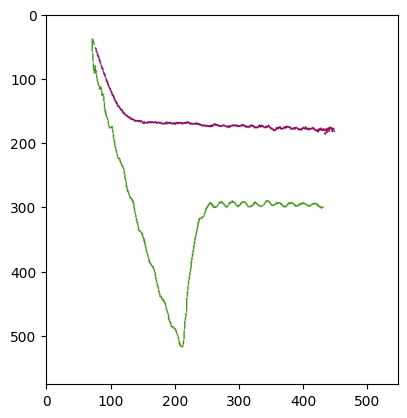

In [ ]:
# Pictures from the trainin set
filename = train_nanodomain_dir + '/' + 'Recorded curve_nanodomain_56.jpg'  # for this dataset for ex the "Recorded curve_nanodomain_751.jpg" belongs to the outside nanodomain
                                                                           # I must correct this  dataset later, but for now it is ok
# Load the image in memory
image = matplotlib.image.imread(filename)
# Print the image shape
print(image.shape)
# Display the image
plt.imshow(image)
plt.show()

In [ ]:
#  Rescaling the values of the input image from [0, 255] to [0, 1]
data_generator = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, rotation_range=20, zoom_range=0.2, shear_range=0.2, width_shift_range=0.2, height_shift_range=0.2)
# We create that will automatically load the images from the training and validation folders, and will pass them to the model during the training
batch_s=32
train_iterator = data_generator.flow_from_directory(train_dir, class_mode='categorical', batch_size=batch_s, target_size=(128, 128))
validation_iterator = data_generator.flow_from_directory(validation_dir, class_mode='categorical', batch_size=batch_s, target_size=(128, 128))

Found 4000 images belonging to 2 classes.
Found 980 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 128)       0

In [ ]:
# Ruta para guardar el modelo entrenado
model_path = '/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/BiClassC.albicans19-2-2024.h5'

In [ ]:
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    verbose=1,
    mode='min',
    save_best_only=True)

In [ ]:
epocas=20
#FUNCIÓN FIT PARA ENTRENAR

STEP_SIZE_TRAIN=train_iterator.n//train_iterator.batch_size
STEP_SIZE_VALIDATION=validation_iterator.n//validation_iterator.batch_size

history=model.fit(train_iterator,
                  steps_per_epoch=STEP_SIZE_TRAIN,
                  epochs=epocas,
                  validation_data=validation_iterator,
                  validation_steps=STEP_SIZE_VALIDATION,
                  callbacks=[model_checkpoint_callback])

Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8050
Epoch 1: val_loss improved from inf to 0.17640, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/BiClassC.albicans19-2-2024.h5
125/125 [==============================] - 42s 308ms/step - loss: 0.4121 - accuracy: 0.8050 - val_loss: 0.1764 - val_accuracy: 0.9385


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.9530
Epoch 2: val_loss improved from 0.17640 to 0.15424, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/BiClassC.albicans19-2-2024.h5
125/125 [==============================] - 35s 284ms/step - loss: 0.1335 - accuracy: 0.9530 - val_loss: 0.1542 - val_accuracy: 0.9563
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9745
Epoch 3: val_loss improved from 0.15424 to 0.11652, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/BiClassC.albicans19-2-2024.h5
125/125 [==============================] - 37s 293ms/step - loss: 0.0839 - accuracy: 0.9745 - val_loss: 0.1165 - val_accuracy: 0.9667
Epoch 4/20
125/125 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9862
Epoch 4: val_loss improved from 0.11652 to 0.07409, saving model to /content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/BiClas

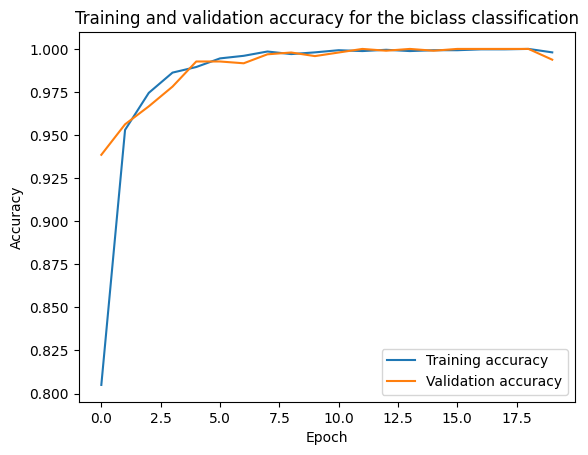

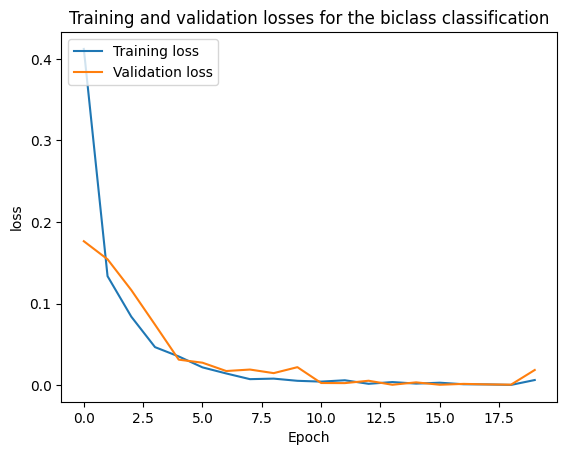

In [ ]:
#To see the model behavior during training
#Accuracy graph
def visualize_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Training and validation accuracy for the biclass classification')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
  plt.show()
#Loss function graph
def visualize_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training and validation losses for the biclass classification')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Training loss', 'Validation loss'], loc='upper left')
  plt.show()
#Accuracy graphic
visualize_accuracy(history)

#Loss function graphic
visualize_loss(history)

In [ ]:
batch_s=32
img_sz=128
data_generator2 = ImageDataGenerator(rescale=1.0/255.0)
validation_iterator3 = data_generator2.flow_from_directory(validation_dir, class_mode='categorical', batch_size=batch_s,
                                                           target_size=(img_sz, img_sz),shuffle=False)

Found 980 images belonging to 2 classes.


In [ ]:
#Load the model previously training
model_n = keras.models.load_model('/content/drive/MyDrive/FilesforDL/CecileEtEtienne/Modelos/BiClassC.albicans19-2-2024.h5')

In [ ]:
#Predict with validation set
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y1_pred = model_n.predict(validation_iterator3, validation_iterator3.n // batch_s+1)
y_pred = np.argmax(y1_pred, axis=1)
print(validation_iterator3.class_indices)

31/31 [==============================] - 3s 91ms/step
{'Nanodomain': 0, 'Outside nanodomain': 1}


Confusion Matrix


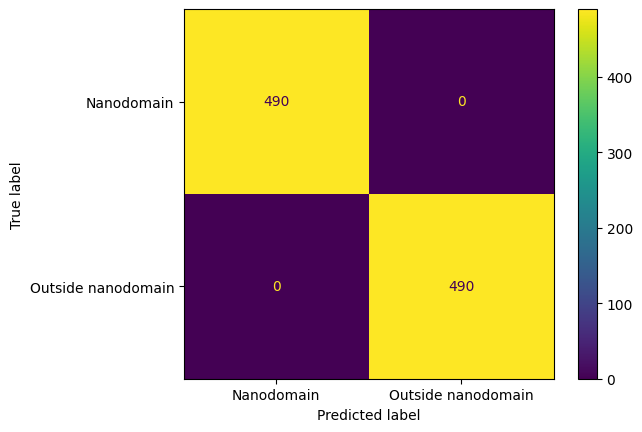

In [ ]:
labels=['Nanodomain', 'Outside nanodomain']
print('Confusion Matrix')
cm=confusion_matrix(validation_iterator3.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

In [ ]:
#To see the model behavior during training
#Accuracy graph
def visualize_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Training and validation accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
  plt.show()
#Loss function graph
def visualize_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training and validation losses')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Training loss', 'Validation loss'], loc='upper left')
  plt.show()
#Accuracy graphic
visualize_accuracy(history)

#Loss function graphic
visualize_loss(history)

In [ ]:
#Classification Report
print('Classification Report')
print(classification_report(validation_iterator.classes, y_pred, target_names=labels))

Classification Report
                    precision    recall  f1-score   support

        Nanodomain       1.00      1.00      1.00       490
Outside nanodomain       1.00      1.00      1.00       490

          accuracy                           1.00       980
         macro avg       1.00      1.00      1.00       980
      weighted avg       1.00      1.00      1.00       980



##  <span style="color:Green"> Conclusion:  For the biclass, the confusion matrix is perfect, accuracy is 100%.  </span>